In [1]:
import pyfits
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.io import fits
import scipy.ndimage as snd
import scipy
%matplotlib inline

//anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


[ '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Bias/Bias.00000001.BIAS.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Bias/Bias.00000002.BIAS.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Bias/Bias.00000003.BIAS.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Bias/Bias.00000004.BIAS.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Bias/Bias.00000005.BIAS.FIT'] ... [ '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000032.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000033.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Saturn/Saturn.00000001.Saturn.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Saturn/Saturn.00000002.Saturn.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Saturn/Saturn.00000003.Saturn.FIT']
Our exposure types ['Bias Frame' 'Dark

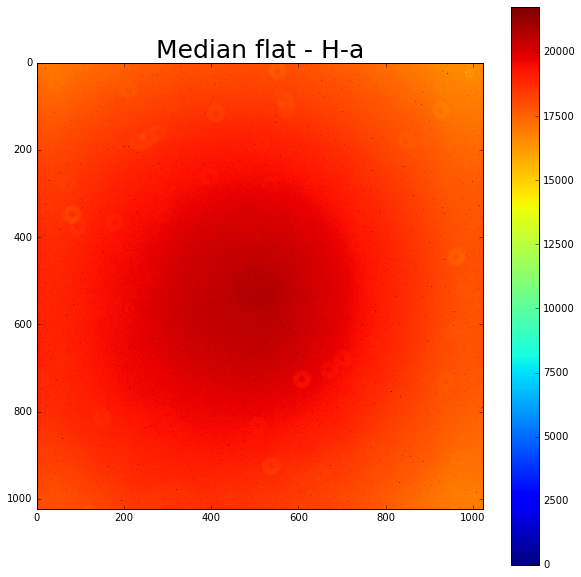

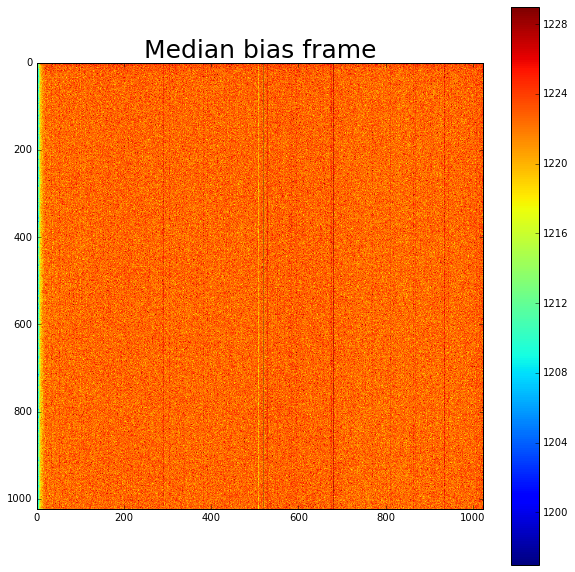

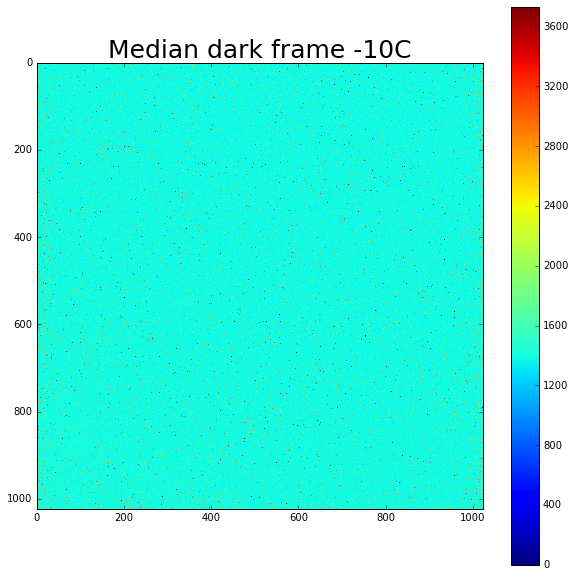

In [2]:
"""
Fit files from 2016

Using getheader to differenciate filetypes

"""



rootdir='/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/'
all_fits_filenames=np.array(glob.glob(rootdir+'*/*.FIT'))
print all_fits_filenames[:5],"...",all_fits_filenames[-5:]

all_exp_types = np.array([pyfits.getheader(fooname)["IMAGETYP"] for fooname in all_fits_filenames])
print "Our exposure types",np.unique(all_exp_types)

print all_exp_types

bias_filenames = all_fits_filenames[np.where(all_exp_types=='Bias Frame')]
print "Number of bias frames",len(bias_filenames)

dark_filenames = np.sort(all_fits_filenames[np.where(all_exp_types=='Dark Frame')])
dark_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in dark_filenames])
dark_temperature=np.array([pyfits.getheader(fooname)["CCD-TEMP"] for fooname in dark_filenames])
print "Number of darks and exposure times",str(len(dark_filenames)),np.unique(dark_exptimes)
print "Temperatures",str(len(dark_filenames)),np.unique(dark_temperature)

flat_filenames = all_fits_filenames[np.where(all_exp_types=='Flat Field')]
flat_filter_names=np.array([pyfits.getheader(fooname)["FILTER"] for fooname in flat_filenames])
flat_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in flat_filenames])
print "Flat filters and exposure times",np.unique(flat_filter_names),(flat_exptimes)

light_filenames = all_fits_filenames[np.where(all_exp_types=='Light Frame')]
light_folders = np.array([fooname.split('/')[-2] for fooname in light_filenames])

m51_filenames=light_filenames[np.where(light_folders=='M51')]

m51_filter_names=np.array([pyfits.getheader(fooname)["FILTER"] for fooname in m51_filenames])
m51_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in m51_filenames])
print "M51 filters exposed and exposure times",np.unique(m51_filter_names),np.unique(m51_exptimes)


M51_temperature=np.array([pyfits.getheader(fooname)["CCD-TEMP"] for fooname in m51_filenames])
print "Temperatures",str(len(m51_filenames)),np.unique(M51_temperature)

print len(m51_filenames)
""""
Median Function & Images of Flats, Bias, and  Darks

"""

def median_combine(filelist):
    allimgs=[]
    for filename in filelist: allimgs.append(pyfits.getdata(filename))
    allimgs=np.array(allimgs)
    medianimg=np.median(allimgs,axis=0)
    return medianimg


thefilt='H-a'
flat_time=90
dark_time=300


median_dark=median_combine(dark_filenames[:][np.where((dark_exptimes==dark_time))])

median_flat=median_combine(flat_filenames[np.where((flat_filter_names==thefilt) & 
                                                             (flat_exptimes==flat_time))])
median_bias=median_combine(bias_filenames[:50])   # note that I take only the first 50 biases, to save time




plt.figure(figsize=(10,10))
plt.imshow(median_flat,vmax=np.median(median_flat)+3*np.std(median_flat))
plt.title('Median flat - '+thefilt,fontsize=25)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(median_bias,vmax=np.median(median_bias)+3*np.std(median_bias))
plt.title('Median bias frame',fontsize=25)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(median_dark,vmax=np.median(median_dark)+3*np.std(median_dark))
plt.title('Median dark frame -10C',fontsize=25)
plt.colorbar()



In [277]:
def reduce_raw_science_frames(science_filelist,median_bias,median_flat,median_dark):
    allreducedimgs=[]
    normed_flat=(median_flat-median_bias)/np.median(median_flat-median_bias)
    for filename in science_filelist: 
        science_frame=pyfits.getdata(filename)
        reduced_frame=(science_frame-median_dark)/normed_flat
        allreducedimgs.append(reduced_frame)
    allreducedimgs=np.array(allreducedimgs)
    return allreducedimgs

[ '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000021.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000022.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000023.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000024.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000025.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000026.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000027.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000028.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000029.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.00000030.M_51.FIT'
 '/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/M51/M51.000000

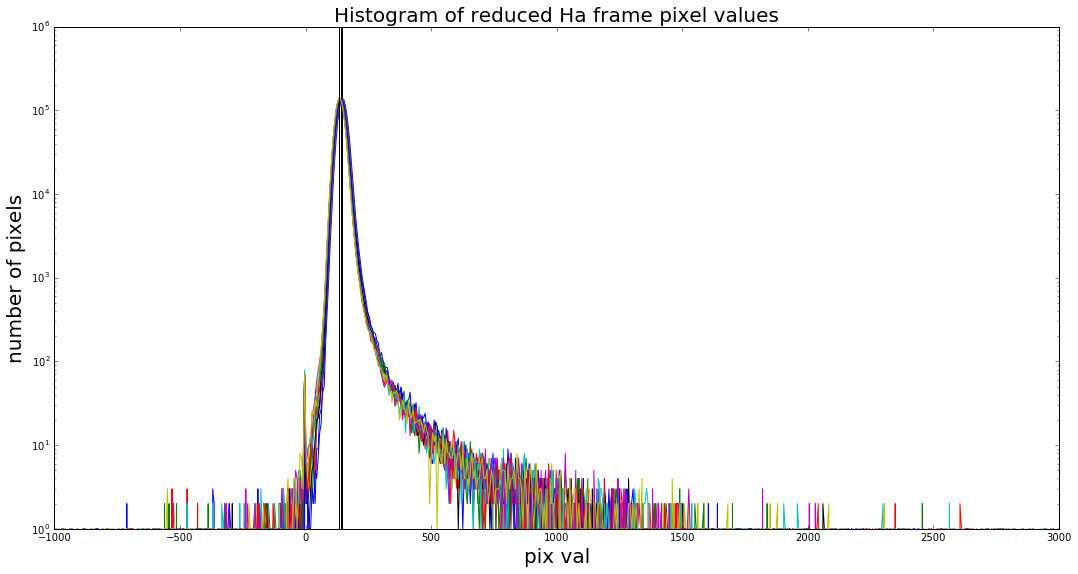

In [278]:
m51_time=300
science_filenames=np.sort(m51_filenames[np.where((m51_filter_names==thefilt) & (m51_exptimes==m51_time))])[1:]
science_filenames=science_filenames
print science_filenames
science_reduced = reduce_raw_science_frames(science_filenames,median_bias,median_flat,median_dark)
science_exptimes=np.array([pyfits.getheader(fooname)["EXPTIME"] for fooname in science_filenames])
print science_exptimes
for i in range(len(science_reduced)):
    pyfits.writeto(science_filenames[i].split('.FIT')[0]+'-reduced.fits',science_reduced[i],
                   clobber=True,header=pyfits.getheader(science_filenames[i]))

plt.figure(figsize=(18,9))
skylevels=[]
for i in range(len(science_reduced)):
    numpix,aduvals=np.histogram(science_reduced[i].flatten(),bins=1000,range=[-1000,5e3])
    skylevel=aduvals[np.where(numpix==numpix.max())][0]
    skylevels.append(skylevel)
    plt.plot(aduvals[:-1],numpix)
    plt.axvline(skylevel,color='k')
plt.xlabel('pix val',fontsize=20)
plt.ylabel('number of pixels',fontsize=20)
plt.yscale('log')

plt.xlim(-1000,3000)

print skylevels
plt.title('Histogram of reduced Ha frame pixel values',fontsize=20)

print len(science_filenames)



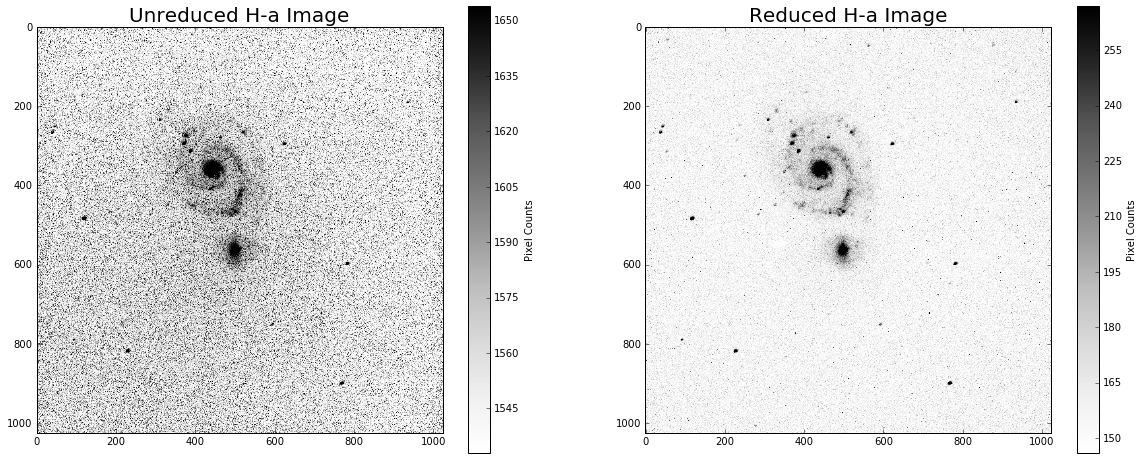

In [332]:
testnum=0
nstd=10
unreduced=pyfits.getdata(science_filenames[testnum])
plt.figure(figsize=(20,8))
plt.subplot(121)
vmin_unred=np.median(median_dark)+skylevels[testnum]
plt.imshow(unreduced,cmap='Greys',vmin=vmin_unred,vmax=vmin_unred+nstd*np.sqrt(skylevels[testnum]))
plt.colorbar(label="Pixel Counts")
plt.title('Unreduced H-a Image',fontsize=20)
plt.subplot(122)
plt.imshow(science_reduced[testnum],cmap='Greys',vmin=skylevels[testnum],vmax=skylevels[testnum]+nstd*np.sqrt(skylevels[testnum]))
plt.colorbar(label="Pixel Counts")
#plt.suptitle('The difference between reduced and unreduced',fontsize=25)
plt.title('Reduced H-a Image',fontsize=20)


In [280]:
def find_object_centroids_filterbysize(img,threshold,minsize):
    labels, num = snd.label(img > threshold, np.ones((3,3)))     # scipy labels/segments the image using a threshold
    centers = snd.center_of_mass(img, labels, range(1,num+1))    # scipy calculates the center of mass on the labeled img
    x = np.array(centers)[:,1]
    y = np.array(centers)[:,0]
    slices=snd.find_objects(labels)
    xs=np.array([objlabel[1].stop-objlabel[1].start for objlabel in slices])  # takes the min and max label slices
    ys=np.array([objlabel[0].stop-objlabel[0].start for objlabel in slices])  #  to find a rough object size

    maxsize=20    # I hardcoded this in so that some spurious objects would be skipped. Change/delete if you like
    bigenough=np.where((xs>minsize) & (ys>minsize) & (xs<maxsize) & (ys<maxsize))
    xc,yc=x[bigenough],y[bigenough]
    xs,ys=xs[bigenough],ys[bigenough]
    
    print str(len(xc))+' objects found'
    return xc,yc,xs,ys

64 objects found


[0, 1024, 0, 1024]

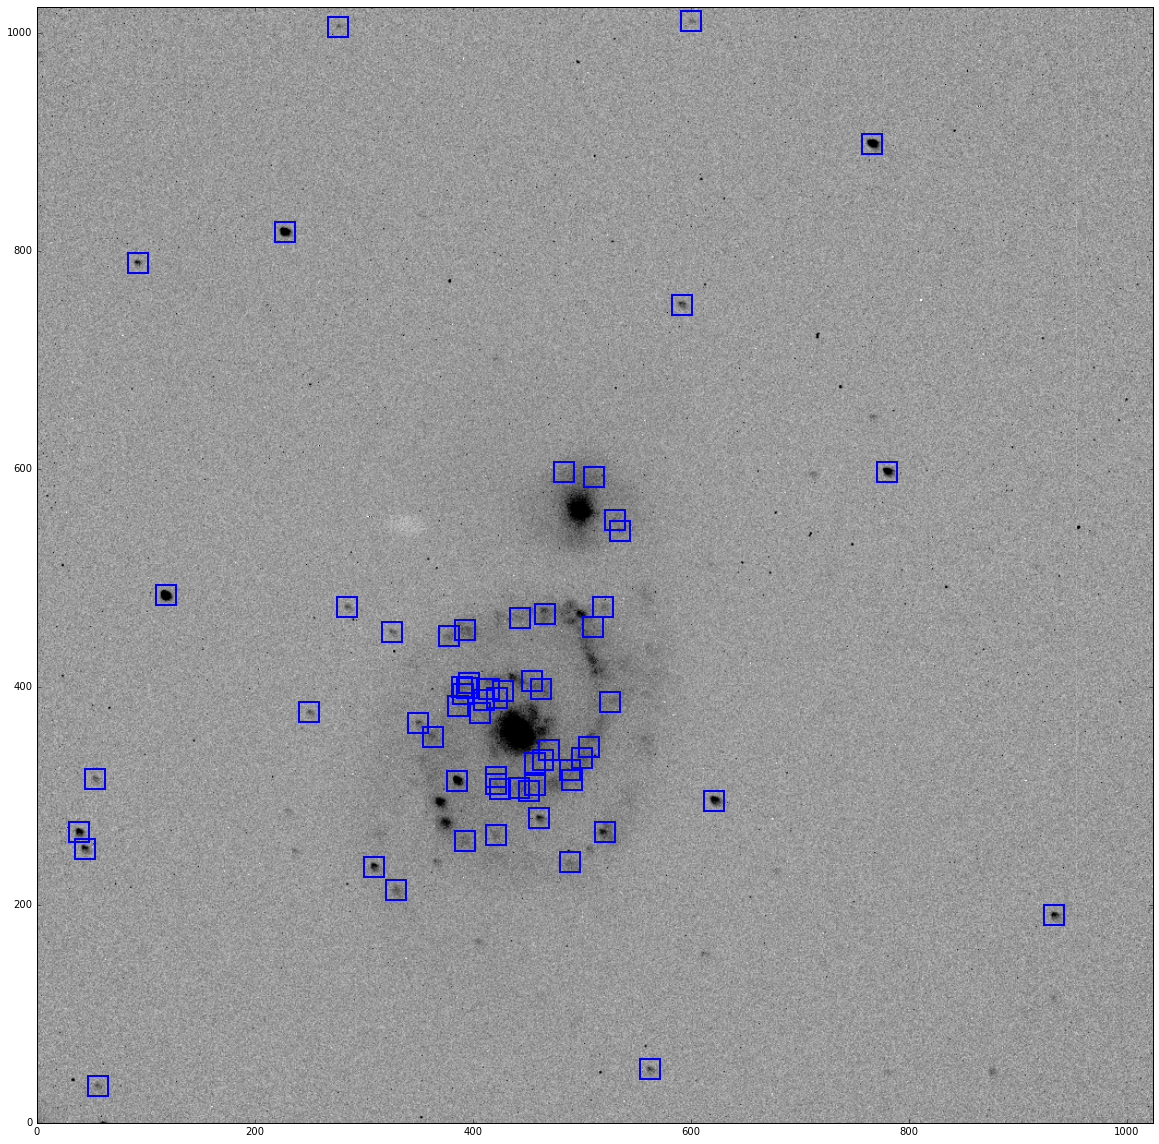

In [281]:
imgnum=0
nstd_aboveskynoise=5
threshold=skylevels[imgnum]+nstd_aboveskynoise*np.sqrt(skylevels[imgnum])   # decide on a threshold using the sky noise
minsize=3

xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[imgnum],threshold,minsize)


plt.figure(figsize=(20,20))
plt.imshow(science_reduced[imgnum],cmap='Greys',vmin=0,vmax=1.5*threshold)
plt.plot(xfoo,yfoo,'rs',mfc='None',markersize=20,markeredgecolor='b',markeredgewidth=2)
plt.axis([0,1024,0,1024])

105 objects found
105 objects found
83 objects found
125 objects found
130 objects found
109 objects found
115 objects found
109 objects found
99 objects found
127 objects found
145 objects found
120 objects found
125 objects found


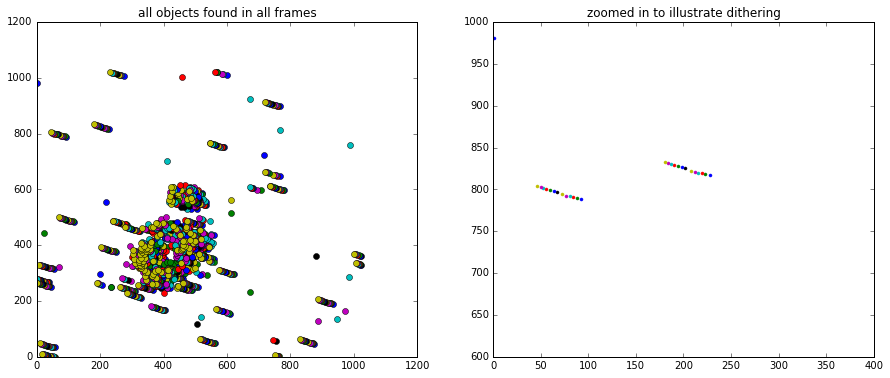

In [282]:
nstd_aboveskynoise=4
thresholds=skylevels+nstd_aboveskynoise*np.sqrt(skylevels)

#thresholds=[threshold]*len(science_reduced)
minsize=3
xc_all,yc_all,xs_all,ys_all=[],[],[],[]
plt.figure(figsize=(15,6))
for i in range(len(science_reduced)):
    xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[i],thresholds[i],minsize)
    xc_all.append(xfoo)
    yc_all.append(yfoo)
    xs_all.append(xsfoo)
    ys_all.append(ysfoo)
    plt.subplot(121)
    plt.plot(xfoo,yfoo,'o')
    plt.subplot(122)
    plt.plot(xfoo,yfoo,'.')
    plt.axis([0,400,600,1000])
plt.subplot(121)
plt.title('all objects found in all frames')
plt.subplot(122)
plt.title('zoomed in to illustrate dithering')

In [283]:
def find_closest(xc0,yc0,xc1,yc1,dr):
    nobjs1=len(xc1)
    x_off,y_off=[],[]
    for i in range(nobjs1):
        poss_match=np.where(np.sqrt((xc1[i]-xc0)**2+(yc1[i]-yc0)**2)<dr)[0]  # for each object in the second catalog, 
        x_off.extend([(xc1[i]-xc0[j]) for j in poss_match])                  #  find matches within a radius dr
        y_off.extend([(yc1[i]-yc0[j]) for j in poss_match])
    x_off=np.array(x_off)
    y_off=np.array(y_off)
    
    n_xoff,xfoo=np.histogram(x_off,bins=dr*2,range=[-dr,dr])   # histogram all the offsets to find the maximum value
    n_yoff,yfoo=np.histogram(y_off,bins=dr*2,range=[-dr,dr])   #  which corresponds to the rough offset between frames
    x_peak=(xfoo[np.where(n_xoff==np.max(n_xoff))])[0]+(xfoo[1]-xfoo[0])/2.
    y_peak=(yfoo[np.where(n_yoff==np.max(n_yoff))])[0]+(yfoo[1]-yfoo[0])/2.   # (note addition of half bin width)
    return x_off,y_off,x_peak,y_peak


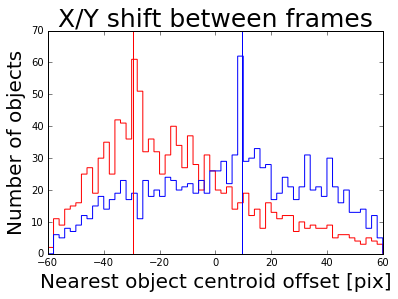

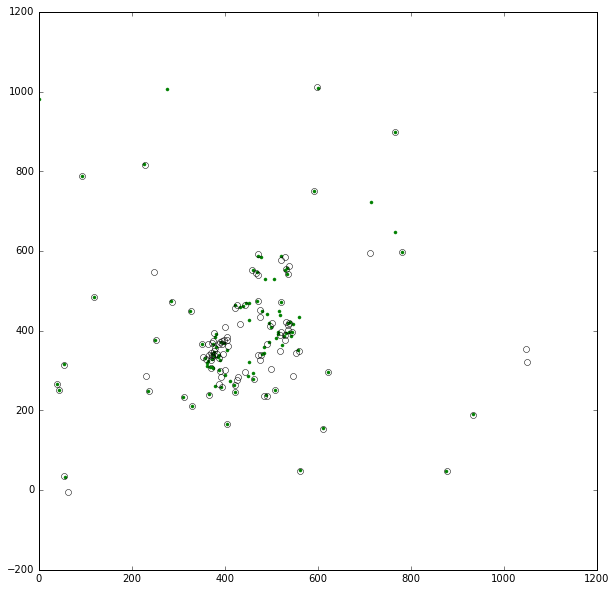

In [284]:
secondnum=7
dr=60
xc0,yc0,xc1,yc1=xc_all[0],yc_all[0],xc_all[secondnum],yc_all[secondnum]
xoff,yoff,xpeak,ypeak=find_closest(xc0,yc0,xc1,yc1,dr)
 
    
plt.hist(xoff,histtype='step',label='x offset',range=[-dr,dr],bins=dr,color='r')
plt.hist(yoff,histtype='step',label='y offset',range=[-dr,dr],bins=dr,color='b')

plt.axvline(xpeak,color='r')
plt.axvline(ypeak,color='b')

plt.xlabel('Nearest object centroid offset [pix]',fontsize=20)
plt.ylabel('Number of objects',fontsize=20)
plt.title('X/Y shift between frames',fontsize=25)

plt.figure(figsize=(10,10))
plt.plot(xc0,yc0,'g.')
plt.plot(xc1-xpeak,yc1-ypeak,'o',mfc='None')


In [285]:
def find_frame_shifts(x0,y0,x1,y1,dr0,nsteps):    #like the def above, take in two sets of coordinates
    xshifts,yshifts=0,0
    drs=[dr0,20,10,5,2.5,1.25]
    for i in range(nsteps):
        dr=dr0/(1.+i)      # slowly reduce the matching radius, to get rid of outliers
        xoff,yoff,xpeak,ypeak=find_closest(x0,y0,x1-xshifts,y1-yshifts,dr)
        n_xoff,xfoo=np.histogram(xoff,bins=50,range=[-dr,dr])
        n_yoff,yfoo=np.histogram(yoff,bins=50,range=[-dr,dr])
        #axvline(xpeak)
        #print xpeak
        if i==0:
            xshift,yshift=xpeak,ypeak    # the first rough offset estimate is the peak of the offset histogram
        else:                            # successive offsets are found by taking the median value of the remainder
            xshift,yshift=np.median(xoff[np.abs(xoff)<dr/2.]),np.median(yoff[np.abs(yoff)<dr/2.])
        xshifts+=xshift        # add in each successive offset to the total
        yshifts+=yshift
        print dr,xshifts,yshifts
        #plot(xshifts,yshifts,'o')
    plt.hist(xoff,histtype='step',color='r',bins=50)
    plt.hist(yoff,histtype='step',color='b',bins=50)
    #plot(yfoo[1:],n_yoff,'b')
    plt.axvline(xshift,color='r')
    plt.axvline(yshift,color='b')
    return xshifts,yshifts

60.0 -46.5 15.5
30.0 -46.3723121054 15.6740792545
20.0 -46.5218702437 15.7792291313
15.0 -46.3976644401 15.7440123883
12.0 -46.4068116622 15.7854509008
10.0 -46.3693458773 15.8141107883


(-46.369345877294094, 15.814110788277787)

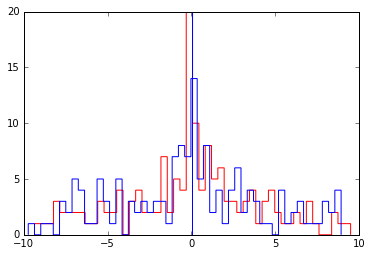

In [286]:
firstnum,secondnum=0,-1
dr=60
xc0,yc0,xc1,yc1=xc_all[firstnum],yc_all[firstnum],xc_all[secondnum],yc_all[secondnum]
find_frame_shifts(xc0,yc0,xc1,yc1,dr,6)

60.0 -4.5 1.5
30.0 -4.54102529086 1.54077355534
20.0 -4.42434222737 1.54077355534
15.0 -4.34609285037 1.6946529667
60.0 -8.5 1.5
30.0 -8.40711957561 1.83467812063
20.0 -8.30241156236 2.01273013148
15.0 -8.32067960501 2.05752883867
60.0 -12.5 2.5
30.0 -12.418280203 2.71484606465
20.0 -12.2088935911 2.91132433099
15.0 -12.1640272676 2.9337731327
60.0 -15.5 3.5
30.0 -15.8056247122 4.04862524088
20.0 -15.6523569735 4.24263759022
15.0 -15.6254562692 4.33562545188
60.0 -19.5 5.5
30.0 -19.4460561679 5.35556906481
20.0 -19.5363813599 5.50754207926
15.0 -19.5628353056 5.53485060627
60.0 -25.5 8.5
30.0 -25.8528833994 7.93459977798
20.0 -25.8888584739 8.0239552504
15.0 -25.8888584739 8.14016213754
60.0 -29.5 9.5
30.0 -29.2774131151 9.59316211449
20.0 -29.2543190036 9.42103464403
15.0 -29.116903555 9.16585577058
60.0 -33.5 10.5
30.0 -33.1157447447 10.7000729699
20.0 -32.8618632933 10.6455160141
15.0 -32.823937705 10.6718874659
60.0 -36.5 11.5
30.0 -36.9730604908 11.8368978594
20.0 -37.1378018201 1

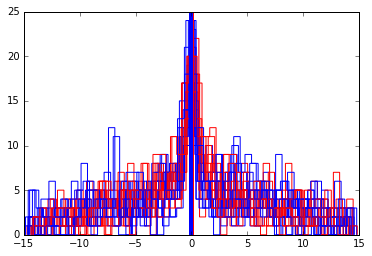

In [287]:
xshifts,yshifts=np.zeros(len(science_reduced)),np.zeros(len(science_reduced))
for secondnum in range(1,len(science_reduced)):
    xshifts[secondnum],yshifts[secondnum]=find_frame_shifts(xc_all[0],yc_all[0],xc_all[secondnum],yc_all[secondnum],dr,4)


In [288]:
science_shifted_rescaled=np.array([snd.interpolation.shift(science_reduced[i],[-yshifts[i],-xshifts[i]],order=5) for i in range(0,len(science_reduced))])
stackedimg=np.median(science_shifted_rescaled,axis=0)-np.median(skylevels)

# Subtracting R band from Halpha image

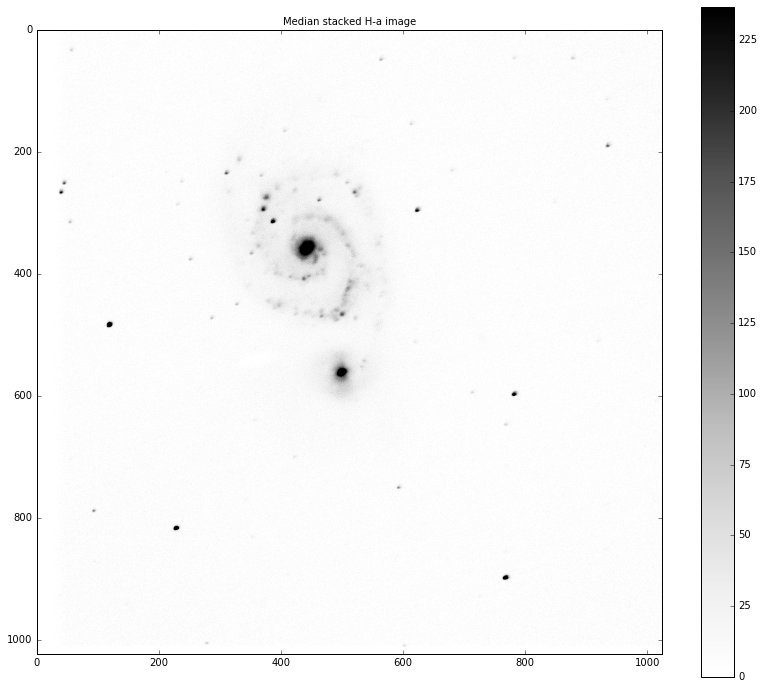

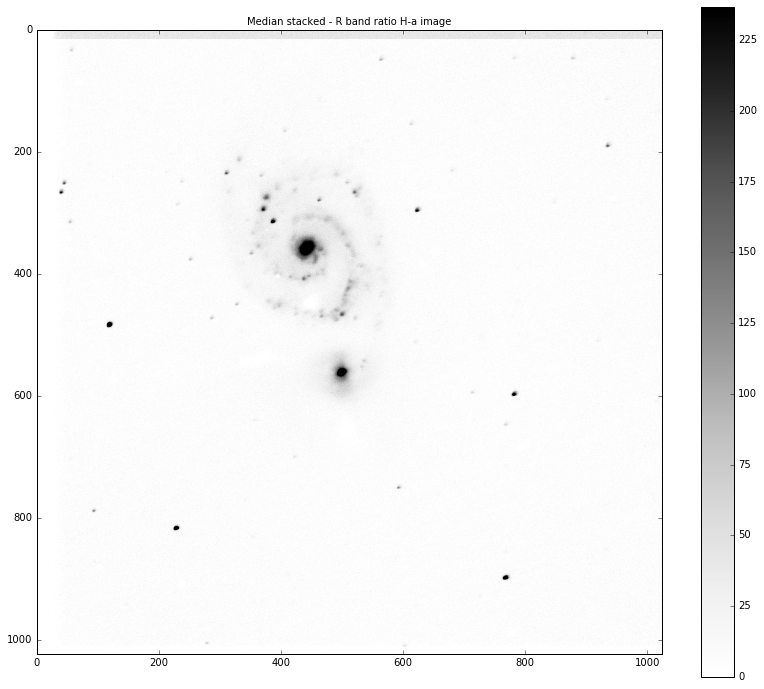

In [289]:
R_Ha_ratio=pyfits.getdata('/Users/noahknoblauch/PHY157/Observing/Ratio_Stacked_R.FITS')

Reduced_Ha=stackedimg-R_Ha_ratio

plt.figure(figsize=(14,12))
plt.title('Median stacked '+thefilt+' image',fontsize=10)
plt.imshow(stackedimg,cmap='Greys',vmin=0,vmax=20*np.sqrt(np.median(skylevels)))
plt.colorbar()
#plt.axis([200,700,200,700])
#pyfits.writeto(rootdir+thefilt+'-median.fits',stackedimg,clobber=True)

plt.figure(figsize=(14,12))
plt.title('Median stacked - R band ratio '+thefilt+' image',fontsize=10)
plt.imshow(Reduced_Ha,cmap='Greys',vmin=0,vmax=20*np.sqrt(np.median(skylevels)))
plt.colorbar()


# Do rotation code here

In [ ]:
pyfits.writeto('/Users/noahknoblauch/PHY157/Observing/Stacked_Ha.FITS',stackedimg,clobber=True)

im0=pyfits.getdata('/Users/noahknoblauch/PHY157/Observing/Stacked_Ha.FITS')
image2=pyfits.getdata('/Users/noahknoblauch/PHY157/Observing/2016-Spring_157/20160517/Rotated_2012_B.FITS')

In [ ]:
rotatedimg=scipy.ndimage.interpolation.rotate(image2, -90, axes=(1, 1), reshape=False,  order=3, mode='constant', cval=0.0)
#pyfits.writeto(rootdir+'ha-median-rotated.fits',rotatedimg,clobber=True)

science_shifted_rescaled=snd.interpolation.shift(rotatedimg,[-350,60],order=5)
im1=science_shifted_rescaled

plt.imshow(im1,cmap='Greys',vmin=0,vmax=1.5*threshold)
plt.imshow(im0,cmap='Greys',vmin=0,vmax=100,alpha=.3)


In [ ]:
nstd_aboveskynoise=8
minsize=6
skylevel0,skylevel1=np.median(im0[im0>0]),np.median(im1[im1>0])
x0,y0,xsfoo,ysfoo=find_object_centroids_filterbysize(im0,skylevel0+nstd_aboveskynoise*np.sqrt(skylevel0),minsize)
x1,y1,xsfoo,ysfoo=find_object_centroids_filterbysize(im1,skylevel1+nstd_aboveskynoise*np.sqrt(skylevel1),minsize)

plt.plot(x0,y0,'bo',alpha=.4)
plt.plot(x1,y1,'ro',alpha=.4)

In [ ]:
dr=200
xc0,yc0,xc1,yc1=x0,y0,x1,y1
x_off_r,y_off_r=find_frame_shifts(xc0,yc0,xc1,yc1,dr,2)

In [ ]:
plt.figure(figsize=(10,10))
plt.title('H-alpha to B frame centroid rotation, seen after offset correction')
plt.plot(x0,y0,'bo',alpha=.4)
plt.plot(x1-x_off_r,y1-y_off_r,'ro',alpha=.4)

In [ ]:
import scipy
from scipy import optimize
def dist_resids_with_rot(ang,x0,x1,y0,y1,dr):
    x1s,y1s=x1-512,y1-512
    angrad=ang/180.*np.pi
    xr=x1s*np.cos(angrad)-y1s*np.sin(angrad)+512
    yr=x1s*np.sin(angrad)+y1s*np.cos(angrad)+512
    xoff,yoff,xpeak,ypeak=find_closest(x0,y0,xr,yr,dr)
    return np.sqrt((xoff-xpeak)**2+(yoff-ypeak)**2)
params,cov,info,mesg,foo=optimize.leastsq(dist_resids_with_rot,0,
                                          args=(x0,x1-x_off_r,y0,y1-y_off_r,10),full_output=True)
angrad=params/180.*np.pi
print "Rotation in degrees between frames",params

In [ ]:
rotatedimg=scipy.ndimage.interpolation.rotate(im1, -90, axes=(1, 1), reshape=False,  order=3, mode='constant', cval=0.0)
#pyfits.writeto(rootdir+'ha-median-rotated.fits',rotatedimg,clobber=True)


In [ ]:
x1_r,y1_r,xsfoo,ysfoo=find_object_centroids_filterbysize(rotatedimg,skylevel1+nstd_aboveskynoise*np.sqrt(skylevel1),minsize)

In [ ]:
dr=200
x_off_r,y_off_r=find_frame_shifts(x0,y0,x1_r,y1_r,dr,1)

In [ ]:
plt.plot(x0,y0,'bo',alpha=.4)
plt.plot(x1_r-x_off_r,y1_r-y_off_r,'ro',alpha=.4)

In [ ]:
img_rotated_shifted=snd.interpolation.shift(rotatedimg,[-y_off_r,-x_off_r],order=5)

In [ ]:
plt.imshow(img_rotated_shifted,vmin=0,vmax=100,cmap='Reds')
plt.imshow(im0,cmap='Blues',vmin=0,vmax=100,alpha=.3)
plt.axis([0,1024,0,1024])
plt.axis('off')


In [ ]:
nstd_aboveskynoise=4
thresholds=skylevels+nstd_aboveskynoise*np.sqrt(skylevels)

#thresholds=[threshold]*len(science_reduced)
minsize=3
xc_all,yc_all,xs_all,ys_all=[],[],[],[]
plt.figure(figsize=(15,6))
for i in range(len(science_reduced)):
    xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[i],thresholds[i],minsize)
    xc_all.append(xfoo)
    yc_all.append(yfoo)
    xs_all.append(xsfoo)
    ys_all.append(ysfoo)
    plt.subplot(121)
    plt.plot(xfoo,yfoo,'o')
    plt.subplot(122)
    plt.plot(xfoo,yfoo,'.')
    plt.axis([0,400,600,1000])
plt.subplot(121)
plt.title('all objects found in all frames')
plt.subplot(122)
plt.title('zoomed in to illustrate dithering')

In [ ]:
science_shifted_rescaled=snd.interpolation.shift(rotatedimg,[-350,60],order=5)

In [ ]:
plt.imshow(science_shifted_rescaled,cmap='Greys',vmin=0,vmax=1.5*threshold)
plt.imshow(im0,cmap='Greys',vmin=0,vmax=100,alpha=.3)

# Calibration Ha star

In [339]:
dark_calib=median_dark*(180.0/300.0)

calibfilename=[rootdir+'calibration/Feige66.00000036.M_51.FIT']
vcalib_red=reduce_raw_science_frames(calibfilename,median_bias,median_flat,dark_calib)[0]



#print median_dark
print vcalib_red
#print median_flat

AttributeError: 'list' object has no attribute 'rfind'

In [337]:
print median_bias

[[ 1206.   1206.   1213.  ...,  1224.5  1225.   1228.5]
 [ 1206.   1205.5  1213.  ...,  1224.   1223.   1227. ]
 [ 1206.5  1208.   1215.  ...,  1223.5  1226.5  1228. ]
 ..., 
 [ 1203.   1201.5  1212.5 ...,  1224.   1221.   1221.5]
 [ 1203.5  1201.   1210.  ...,  1224.   1223.5  1225.5]
 [ 1206.   1201.   1209.  ...,  1219.5  1224.5  1223.5]]


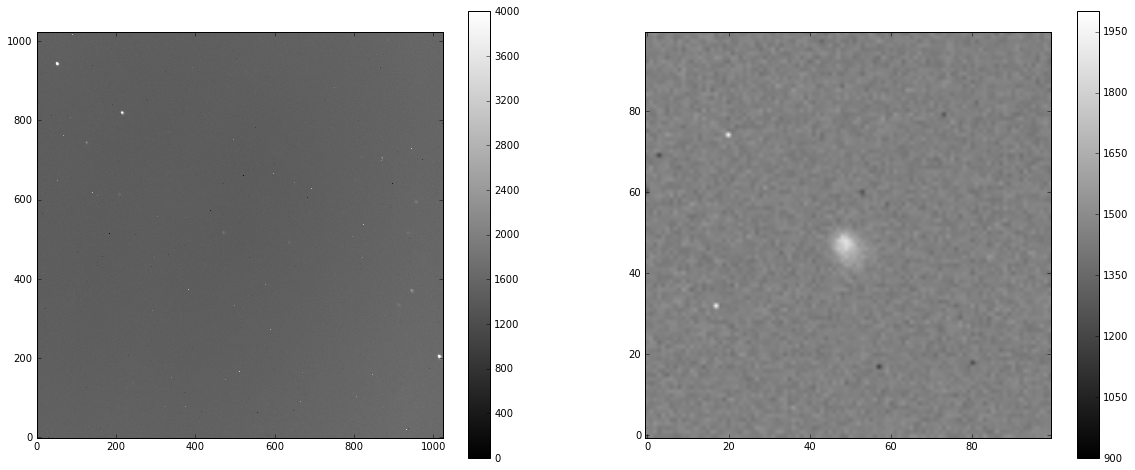

In [293]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(vcalib_red,vmin=0,vmax=4000,cmap='gray',origin='lower')
plt.colorbar()
cal_snip=vcalib_red[470:570,420:520]
plt.subplot(122)
plt.imshow(cal_snip,vmin=900,vmax=2000,cmap='gray',origin='lower')
plt.colorbar()

1456.86312495 31.9440016764


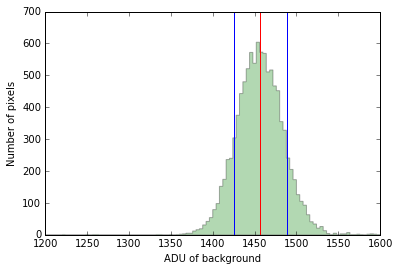

In [294]:
plt.hist(cal_snip.flatten(),bins=100,range=[1200,1600],histtype='stepfilled',color='g',alpha=.3)
plt.xlabel('ADU of background')
plt.ylabel('Number of pixels')
m,s=np.mean(cal_snip[cal_snip<3000]),np.std(cal_snip[cal_snip<3000])
plt.axvline(m-s),plt.axvline(m+s),plt.axvline(m,color='r')
print m,s

In [295]:
xc,yc=0,0
pixsum=0
nx,ny=np.shape(cal_snip)
for i in range(nx):
    for j in range(ny):
        if cal_snip[j,i]>1400:
            xc+=cal_snip[j,i]*i
            yc+=cal_snip[j,i]*j
            pixsum+=cal_snip[j,i]
xc,yc=xc/pixsum,yc/pixsum
print xc,yc

49.4091287878 49.4429189774


[25, 80, 30, 80]

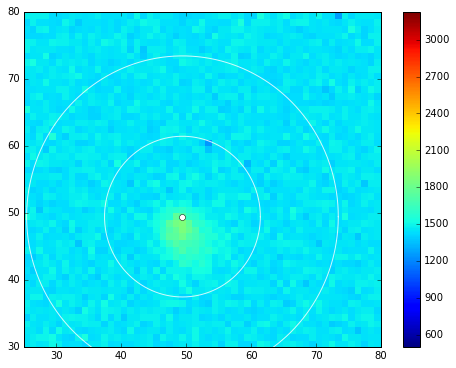

In [296]:
dr=12
r=np.arange(0,30,dr)
phi=np.linspace(0,2*np.pi,1000)


plt.figure(figsize=(8,6))
plt.pcolor(cal_snip,vmin=500)
plt.colorbar()
plt.plot(xc,yc,'wo')
for i in range(len(r)): plt.plot(r[i]*np.cos(phi)+xc,r[i]*np.sin(phi)+yc,'w',alpha=.8)
plt.axis([25,80,30,80])

In [297]:
ann_flux=np.zeros(len(r))
ann_npix=np.zeros(len(r))
for i in range(nx):
    for j in range(ny):
        rdist=np.sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):
                ann_flux[k]+=cal_snip[j,i]
                ann_npix[k]+=1


print r,ann_flux-ann_npix*m,(ann_flux-m*ann_npix)/ann_npix

[ 0 12 24] [ 12964.08534463  -3188.15028052  -5070.88239213] [ 28.49249526  -2.35809932  -2.24077879]


In [298]:
cal_exptime=float(pyfits.getheader(calibfilename[0])['EXPTIME'])
cal_airmass=float(pyfits.getheader(calibfilename[0])['AIRMASS'])
cal_vflux=ann_flux[0]-ann_npix[0]*m
print "Exposure time is: "+ str(cal_exptime)
print "Flux is: " +str(cal_vflux)

cal_vmag=-2.5*np.log10(cal_vflux/cal_exptime)
print "Instrumental magnitude is, -2.5*log10(flux/time): " + str(cal_vmag)

cal_mag_ext=.15*cal_airmass
print "The airmass is: " +str(cal_airmass)+", so given .15 magnitudes/airmass extinction, there are: " +str(cal_mag_ext)
print " magnitudes of extincion."

cal_vmag0=cal_vmag+cal_mag_ext
print "So our final instrum. magnitude in H-a, removing atmospheric effects, is: " +str(cal_vmag0)


landolt_vmag=11.037
cal_vzpt=landolt_vmag-cal_vmag0
print "Standard Feige 66 magnitude is 11.037, so our zeropoint is then: " +str(cal_vzpt)


Exposure time is: 180.0
Flux is: 12964.0853446
Instrumental magnitude is, -2.5*log10(flux/time): -4.64367344074
The airmass is: 1.28613078432, so given .15 magnitudes/airmass extinction, there are: 0.192919617648
 magnitudes of extincion.
So our final instrum. magnitude in H-a, removing atmospheric effects, is: -4.45075382309
Standard Feige 66 magnitude is 11.037, so our zeropoint is then: 15.4877538231


[240, 640, 160, 560]

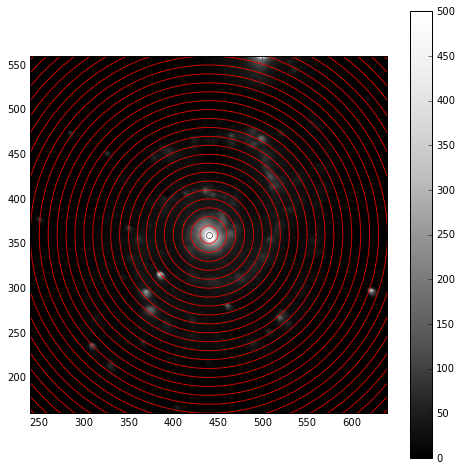

In [299]:
dr=10
r=np.arange(0,300,dr)
phi=np.linspace(0,2*np.pi,1000)
xc,yc=440,360


plt.figure(figsize=(8,8))
m51_vsnip=Reduced_Ha[325:475,325:475]
plt.imshow(Reduced_Ha,vmin=0,vmax=.5e3,cmap='Greys_r')
plt.colorbar()

plt.plot(xc,yc,'wo')
for i in range(len(r)):plt.plot(r[i]*np.cos(phi)+xc,r[i]*np.sin(phi)+yc,'r',alpha=.8)
plt.axis([xc-200,xc+200,yc-200,yc+200])

3.32833759762


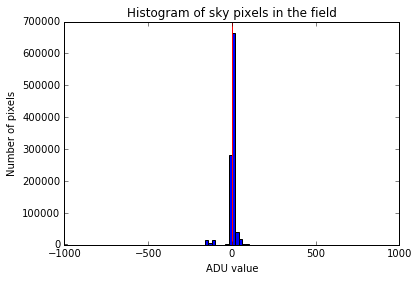

In [300]:
plt.hist(Reduced_Ha.flatten(),range=[-1000,1000],bins=100)
plt.xlabel('ADU value')
plt.ylabel('Number of pixels')
plt.title('Histogram of sky pixels in the field')
bkg=np.median(Reduced_Ha)
plt.axvline(bkg,color='r')
print bkg

In [301]:
nx,ny=np.shape(Reduced_Ha)
ann_flux=np.zeros(len(r))
ann_npix=np.zeros(len(r))
# this loops over every pixel in the image (which is a rather brute force method)
for i in range(nx):
    for j in range(ny):
        rdist=np.sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):     # if the pixel is insize the kth aperture, add it to the tally
                ann_flux[k]+=Reduced_Ha[j,i]
                ann_npix[k]+=1


print r,ann_flux-bkg*ann_npix,(ann_flux-bkg*ann_npix)/ann_npix



[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290] [ 119508.68814428  143870.1553397   113538.45823427   87261.90560461
  100993.71722171  115184.52357825  119909.30362202  123332.10736403
  116622.47940755  142974.79797553  151766.59541405  148835.91676798
  126072.09620432   81074.88862147   60444.99574363   40548.85557166
   36513.82357918   42292.72040864   53520.38195109   63750.6918446
   95566.77425717  106195.56841604   61067.22650301   49100.36052143
   35449.54234393   18954.24407063    9535.67974532    3558.87216697
   -2284.27952115  -10068.93208017] [  3.93120685e+02   1.55032495e+02   7.31562231e+01   3.98092635e+01
   3.60691847e+01   3.35619241e+01   2.94472750e+01   2.62632256e+01
   2.17904483e+01   2.40213034e+01   2.31633998e+01   2.05801876e+01
   1.61300021e+01   9.60602946e+00   6.61903151e+00   4.18547229e+00
   3.52178082e+00   3.85601025e+00   4.61701018e+00   5.20838986e+00
   7.42900919e

In [302]:
print(total_flux)
print cal_vzpt
print bkg

1870746.0288
15.4877538231
3.32833759762


In [325]:

R_Ha_ratio=pyfits.getdata('/Users/noahknoblauch/PHY157/Observing/Ratio_Stacked_R.FITS')

total_flux=(sum(ann_flux[0:18]-bkg*ann_npix[0:18]))


poisson=np.sqrt(total_flux)


mag=-2.5*np.log10(total_flux/300)+0.15*cal_airmass+cal_vzpt

mag_dust=.079
mag1=6.86
print "Magnitude of M51:", mag

flux_jansk=3631*np.power(10,((mag)/-2.5))

print "Flux in janskys:", flux_jansk

c=3e8
f_width=(c/650e-9)-(c/653e-9)

radius_M51=7100
radius_cm=23*9.461e23

Lum_ergs=4*np.pi*radius_cm**2*f_width*flux_jansk*1e-23

print "the luminosity in ergs/s:",Lum_ergs


SFR=Lum_ergs*7.9e-42
print"the star formation rate is:", SFR

Magnitude of M51: 6.19343949759
Flux in janskys: 12.0962415278
the luminosity in ergs/s: 1.52618099953e+42
the star formation rate is: 12.0568298963


In [304]:
m51airmass=float(pyfits.getheader(rootdir+'M51/M51.00000023.M_51.FIT')['AIRMASS'])
pixscale=24*60/1024.
print "The pixel scale is: "+str(pixscale)+ ", airmass is: " + str(m51airmass)

v_surfbright=-2.5*np.log10((ann_flux-bkg*ann_npix)/300.)+2.5*np.log10(ann_npix*pixscale**2)+cal_vzpt+.15*m51airmass



The pixel scale is: 1.40625, airmass is: 1.06916551687


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


[  0.           0.47544643   0.95089286   1.42633929   1.90178571
   2.37723214   2.85267857   3.328125     3.80357143   4.27901786
   4.75446429   5.22991071   5.70535714   6.18080357   6.65625      7.13169643
   7.60714286   8.08258929   8.55803571   9.03348214   9.50892857
   9.984375    10.45982143  10.93526786  11.41071429  11.88616071
  12.36160714  12.83705357  13.3125      13.78794643]
[ 16.09492973  17.10518762  17.92061628  18.58128411  18.68840365
  18.76662734  18.90863169  19.0328743   19.23557905  19.12975304
  19.16923871  19.29762114  19.56215841  20.12488468  20.52925834
  21.02688329  21.21433865  21.11589902  20.92034239  20.78948575
  20.40391723  20.34149115  20.99622078  21.27153062  21.67432631
  22.39727825  23.18365866  24.29581706          nan          nan]


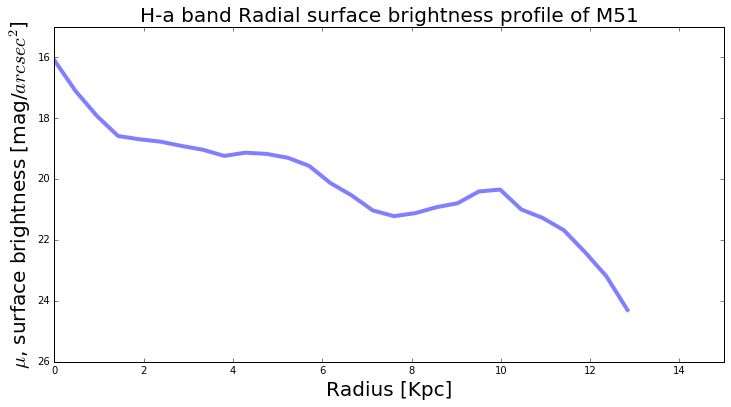

In [344]:
radius=r*pixscale*7100*(1/2.1e5)

plt.figure(figsize=(12,6))
plt.plot(radius,v_surfbright,linewidth=4,alpha=.5)
plt.axis([0,15,26,15])
plt.xlabel('Radius [Kpc]',fontsize=20)
plt.ylabel('$\\mu$, surface brightness [mag/$arcsec^2$]',fontsize=20)
plt.title('H-a band Radial surface brightness profile of M51',fontsize=20)


print radius
print v_surfbright


In [306]:
print ann_flux[0]-ann_npix[0]*m
array=[]
for i in range(len(ann_flux)):
    x=ann_flux[i]-ann_npix[i]*m
    if x<0:
        x=0
        array.append(x)
        all_flux=sum(array)
        mag=-2.5*np.log10(all_flux/300)+0.15*cal_airmass+cal_vzpt




-322365.887212


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


In [307]:
from tempfile import TemporaryFile
outfile = TemporaryFile()

np.savetxt('test1.txt', v_surfbright)